In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import meshplot as mp
import gudhi                 as gd
from tqdm                    import tqdm
from sklearn.cluster import KMeans, AgglomerativeClustering
from mapper import MapperComplex
from SoftMapper import smooth_scheme, compute_mapper, filter_extended_st
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.cm as cm
%matplotlib inline
from scipy.spatial.distance import directed_hausdorff
from scipy.stats import bernoulli

## Import data

In [2]:
files = []
cells = []
libs = []
days = []
with open(r'Datasets/scTDA Tutorial/data.txt', 'r') as f:
    for line in f:
        sp = line[:-1].split('\t')
        files.append(sp[0])
        cells.append(int(sp[1]))
        libs.append(sp[2])
        days.append(int(sp[3]))

In [3]:
time=[]
dfs=[]
for i in range(len(files)):
    f=files[i]
    dfs.append(pd.read_csv(r"Datasets/scTDA Tutorial/"+f,sep="\t",header=None,index_col=0))
    time=time+[days[i]]*dfs[i].shape[1]
df=(pd.concat(dfs,axis=1)).transpose()

## Preprocessed data using Seurat in R

In [4]:
dfn=pd.read_csv(r"Datasets/seurat_normalized.csv",index_col=0).transpose()
dfn

,A1BG,A1BG.AS1,A1CF,A2M,A2M.AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ERCC.00077,ERCC.00069,ERCC.00137,ERCC.00013,ERCC.00168,ERCC.00041,ERCC.00081,ERCC.00086,ERCC.00061,ERCC.00048
X1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.002751,0.0,...,0.000000,0.000000,0.019099,0.0,0.002751,0.0,0.0,0.000000,0.0,0.002751
X2,0.229183,0.0,0.000000,0.0,0.0,0.034521,0.0,0.000000,0.200856,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.011640
X3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.369155,0.0,...,0.001659,0.000000,0.008265,0.0,0.001659,0.0,0.0,0.000000,0.0,0.000000
X4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.224096,0.0,...,0.001673,0.000000,0.014959,0.0,0.000000,0.0,0.0,0.005011,0.0,0.001673
X5,0.000000,0.0,0.014144,0.0,0.0,0.167884,0.0,0.000000,0.206598,0.0,...,0.000791,0.000000,0.003949,0.0,0.000000,0.0,0.0,0.000000,0.0,0.002371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X1525,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.696310,0.0,...,0.000000,0.000000,0.008169,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
X1526,0.104591,0.0,0.000000,0.0,0.0,0.070929,0.0,0.000000,1.265936,0.0,...,0.000000,0.005237,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
X1527,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,1.374573,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
X1528,0.084294,0.0,0.006262,0.0,0.0,0.000000,0.0,0.066819,1.258203,0.0,...,0.018671,0.000000,0.012486,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000


In [5]:
X=np.array(dfn)
(n,p)=X.shape

## Linear filter Optimization

In [6]:
np.random.seed(1)
subset=np.random.randint(low=0,high=len(time),size=500)
delta=np.max([directed_hausdorff(X,X[subset,:]),directed_hausdorff(X[subset,:],X)])

In [7]:
delta

1452.0

In [8]:
X.shape

(1529, 26270)

In [9]:

resolutions=np.array([25])
gain=np.array([0.3])
sigma=1e-5

ag=AgglomerativeClustering(n_clusters=None,distance_threshold=8e-2*delta)

params=tf.Variable(initial_value=np.ones((p,1)).astype(np.float32)/np.sqrt(p),trainable=True)

lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=5e-4, decay_steps=10, decay_rate=1)
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr)

2024-02-09 10:56:32.100777: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-09 10:56:32.100877: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-09 10:56:32.100916: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-09 10:56:32.101037: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-09 10:56:32.101330: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
f=tf.tensordot(X.astype(np.float32),params,axes=1)
mapper=MapperComplex(colors=np.array(time).reshape((-1,1)),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=ag)
mapper.fit(X)
nt=mapper.get_pyvis()
nt.show('sctda_initial.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


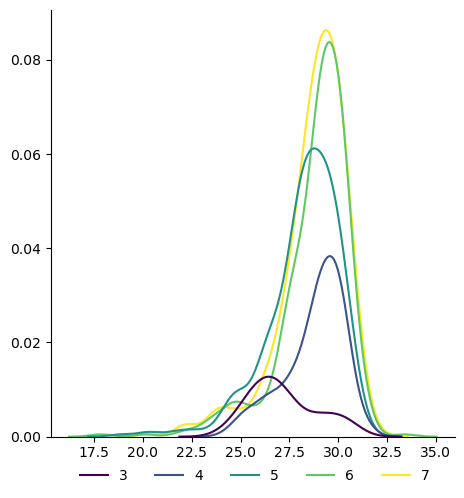

In [11]:
dff=pd.DataFrame(list(zip(time, list(f.numpy().ravel()))),columns =['time', 'filter'])
ax = sns.displot(dff, x="filter", hue="time", kind="kde",palette=cm.viridis)
ax.set(xlabel=None,ylabel=None)
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 0), ncol=5, title=None, frameon=False)
plt.savefig('sctda_densities_initial.png')

In [12]:
losses = []
K=10
with Parallel(n_jobs=-1) as parallel:
    for epoch in tqdm(range(200+1)):

        f=tf.tensordot(X.astype(np.float32),params,axes=1)
        fn=(f-tf.math.reduce_min(f))/(tf.math.reduce_max(f)-tf.math.reduce_min(f))
        scheme=smooth_scheme(fn.numpy(),resolutions,gain,sigma)

        upscheme=np.repeat(scheme,K,axis=0)

        assignments=bernoulli.rvs(upscheme,random_state=0)

        st,clusters=compute_mapper(X,ag,assignments,maximum=5)
        
        with tf.GradientTape() as tape:
            f=tf.tensordot(X.astype(np.float32),params,axes=1)
            f_values=tf.repeat(tf.expand_dims(f,axis=0),clusters.shape[0],axis=0)

            f_values=tf.repeat(f_values,clusters.shape[2],axis=2)

            filtration=tf.math.reduce_sum(f_values*clusters,axis=1)/(np.sum(clusters,axis=1)+1e-10)
            #l=[(_LowerStarSimplexTree(st[k],filtration[k],[0],11,False)[0][0]).reshape(-1,2) for k in range(n)]
            l=parallel(delayed(filter_extended_st)(list(st[k].get_skeleton(1)),filtration.numpy()[k]) 
                for k in range(K))
            loss=0
            
            #dgm=tf.concat([tf.gather(filtration[k],l[k]) for k in range(K)],axis=0)
            for k in range(K):
                dgm=tf.gather(filtration[k],l[k]) 
                loss=loss-tf.math.reduce_sum(tf.math.abs((dgm[:,1]-dgm[:,0])))/K

            regularization = tf.math.square(tf.norm(params)-1)

            loss=loss+regularization

        gradients = tape.gradient(loss, [params])
        
        optimizer.apply_gradients(zip(gradients, [params]))


        losses.append(loss.numpy())

100%|█████████████████████████████████████████| 201/201 [27:31<00:00,  8.22s/it]


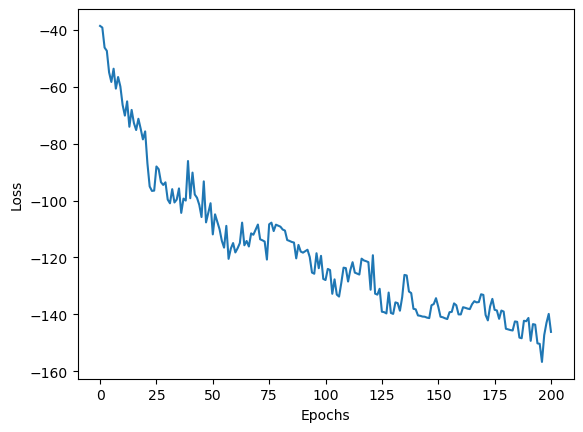

In [13]:
plt.figure()
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [14]:
tf.norm(params)

<tf.Tensor: shape=(), dtype=float32, numpy=1.9762846>

In [15]:
mapper=MapperComplex(colors=np.array(time).reshape((-1,1)),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=ag)
mapper.fit(X)
nt=mapper.get_pyvis()
nt.show('sctda_final.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


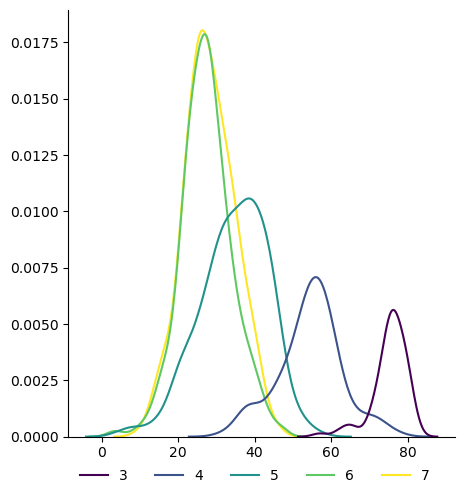

In [16]:
dff=pd.DataFrame(list(zip(time, list(f.numpy().ravel()))),columns =['time', 'filter'])
ax = sns.displot(dff, x="filter", hue="time", kind="kde",palette=cm.viridis)
ax.set(xlabel=None,ylabel=None)
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 0), ncol=5, title=None, frameon=False)
plt.savefig('sctda_densities_final.png')

In [17]:
from scipy.stats import pearsonr
initialparams=tf.Variable(initial_value=np.ones((p,1)).astype(np.float32)/np.sqrt(p),trainable=True)
fi=tf.tensordot(X.astype(np.float32),initialparams,axes=1)
pearsonr(fi.numpy()[:,0],time)

PearsonRResult(statistic=0.13308881265698216, pvalue=1.759614277509779e-07)

In [18]:
pearsonr(f.numpy()[:,0],time)

PearsonRResult(statistic=-0.7517116728368803, pvalue=2.3255737887446518e-278)

In [19]:
mapper=MapperComplex(colors=np.array(dfn['HTR3E']).reshape((-1,1)),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=ag)
mapper.fit(X)
nt=mapper.get_pyvis(cmap=cm.hot)
nt.show('sctda_gene1.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [20]:
mapper=MapperComplex(colors=np.array(dfn['CDX1']).reshape((-1,1)),filters=f.numpy(),resolutions=resolutions, gains=gain, clustering=ag)
mapper.fit(X)
nt=mapper.get_pyvis(cmap=cm.hot)
nt.show('sctda_gene2.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
